##Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lmfit as fitter
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#Read in data calibrated VWC and PAW data
Data = pd.read_pickle('.\DataFrames\LysoVWC_df')
#Data.columns = Data.columns.swaplevel('Sensor','Depth') #get index in the right order for graphing

#Read in calibration coefficients calculated in C:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration.ipynb
SensorCoefficients = pd.read_pickle('.\Calibration\CS650Calibration.pkl')


#Bring in index for horizion types
HorizonIndex=pd.read_csv('.\IndexFiles\HorizonIndex.csv', #specify file path for data to read in
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

DrainageMask = pd.read_pickle('.\Dataframes\DrainageMask')
Drainage = pd.read_pickle('.\Dataframes\Drainage')
MetData= pd.read_csv('ETData.txt',index_col=0)
MetData.index = MetData.index.to_datetime()

In [3]:
Data.where(Data<0.5,np.nan,inplace=True)

##Produce profile soil water content graphs

In [4]:
Accum = np.add(Data.ix[:,'D1'].values * 150, Data.ix[:,'D2'].values * 150)
Accum = np.add(Accum, Data.ix[:,'D3'].values * 150)
Accum = np.add(Accum, Data.ix[:,'D4'].values * 150)
ProfileWater = pd.DataFrame(index = Data.index, data = Accum, columns = Data.ix[:,'D1'].columns)

C:\Anaconda\lib\site-packages\matplotlib\axes\_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


<function matplotlib.pyplot.tight_layout>

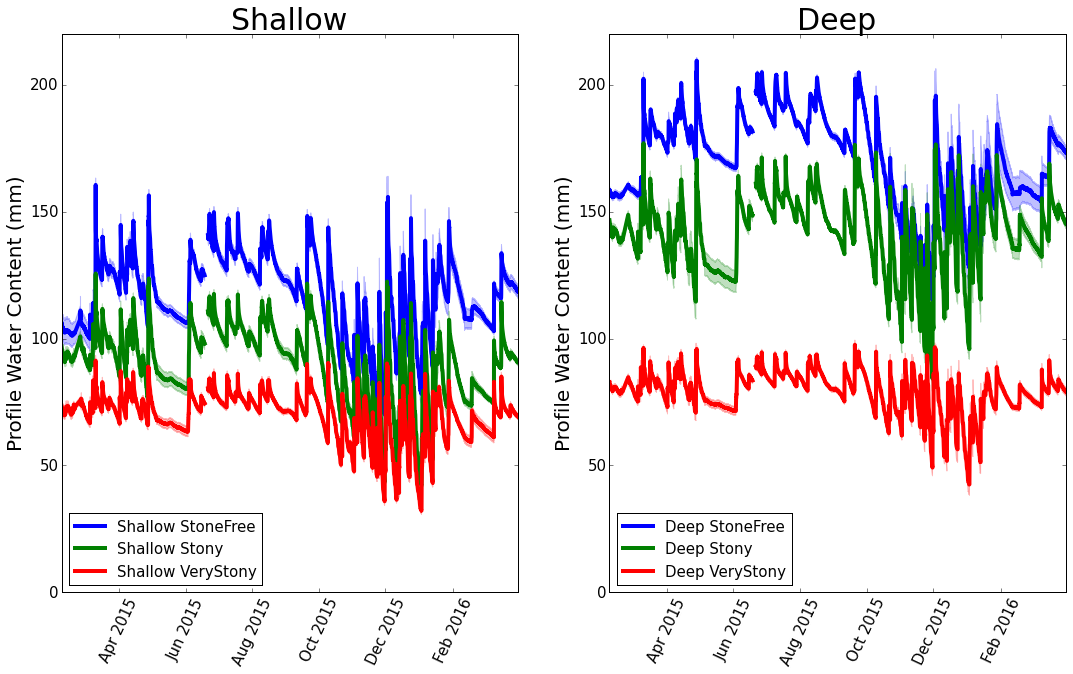

In [5]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,10))

GravPos = 0
for Grav in Gravels:
    fig = Graph.add_subplot(1,2,GravPos)
    StonPos = 0
    for Ston in Stones:
        median = ProfileWater.ix[:,(Grav,Ston)].median(axis=1)
        SEM = ProfileWater.ix[:,(Grav,Ston)].std(axis=1)/np.sqrt(4)
        Upper = median + SEM
        Lower = median - SEM
        plt.fill_between(ProfileWater.ix[:,(Grav,Ston)].index,
                 Upper,
                 Lower,
                 color = colors[StonPos],alpha=0.25)
        plt.plot(ProfileWater.ix[:,(Grav,Ston)].index,median,color=colors[StonPos],
                 linewidth = 4,
                 label = Grav+' ' +Ston)
        StonPos += 1
        plt.title(Grav, fontsize=30)
    GravPos +=1
    plt.ylim(0,220)
    plt.ylabel('Profile Water Content (mm)', fontsize=20)
    plt.xticks(rotation=65)
    plt.tick_params(labelsize=15)    
    plt.legend(loc=3,numpoints=1,fontsize = 15)
plt.tight_layout


##Graph plot volumetric water content by layer

<function matplotlib.pyplot.tight_layout>

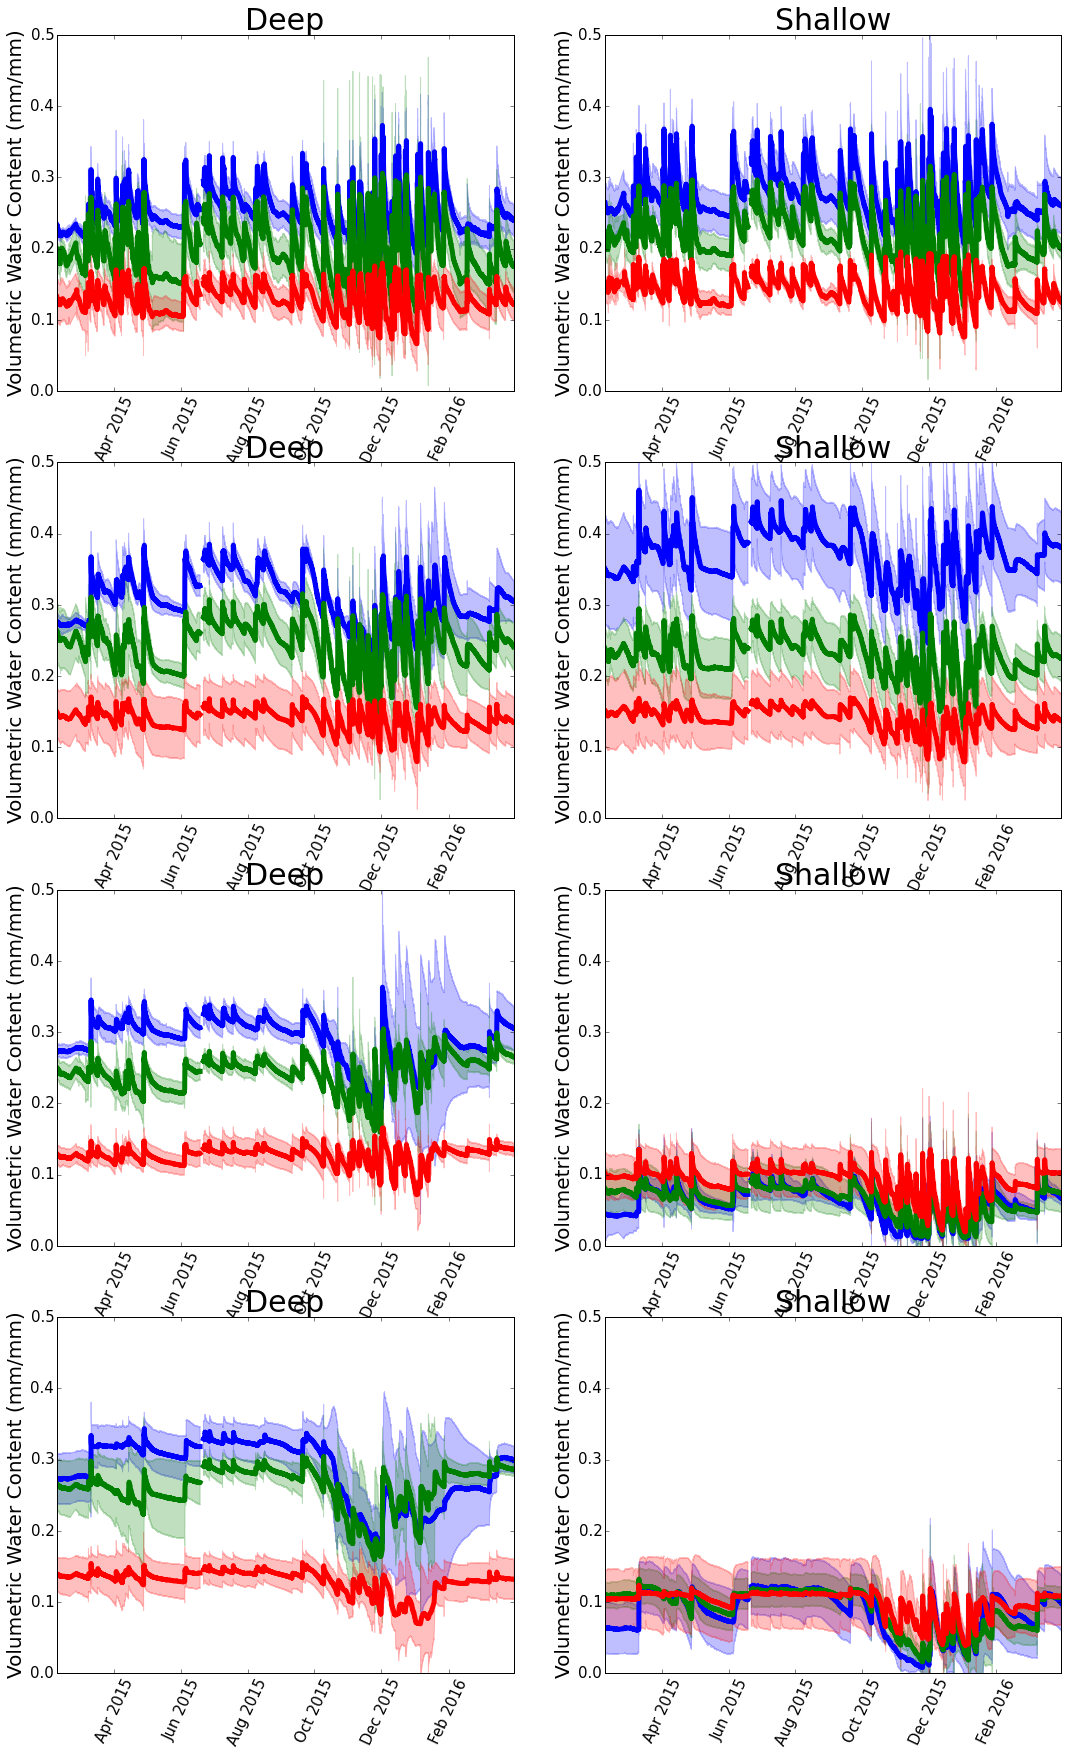

In [6]:
Depths = ['D1','D2','D3','D4']
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,60))

Pos = 1
for Depth in Depths:    
    for Grav in Gravels:
        fig = Graph.add_subplot(8,2,Pos)
        StonPos = 0
        for Ston in Stones:
            median = Data.ix[:,(Depth,Grav,Ston)].median(axis=1)
            SE = Data.ix[:,(Depth,Grav,Ston)].std(axis=1)
            Upper = median + SE *2
            Lower = median - SE *2
            plt.fill_between(Data.ix[:,(Depth,Grav,Ston)].index,
                     Upper,
                     Lower,
                     color = colors[StonPos],alpha=0.25)
            plt.plot(Data.ix[:,(Depth,Grav,Ston)].index,median,color=colors[StonPos],
                     linewidth = 5,
                     label = Grav+' ' +Ston)
            StonPos += 1
            plt.title(Grav, fontsize=30)
        Pos +=1
        plt.ylim(0,0.5)
        plt.ylabel('Volumetric Water Content (mm/mm)', fontsize=20)
        plt.xticks(rotation=65)
        plt.tick_params(labelsize=15)    
        #plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

##Create and populate Plant Available Water (PAW) data frame

In [78]:
ROData = Data.copy()
ROData.columns = ROData.columns.swaplevel('Sensor','Depth') #get index in the right order for graphing
PAW = pd.DataFrame(index = Data.index, columns = ROData.columns)  #Set up empty dataframe with the same index and column structure as TDR dataPAW = pd.DataFrame(index = VWC.index, columns = VWC.columns)  #Set up empty dataframe with the same index and column structure as TDR data
for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    Horizon = HorizonIndex.ix[X,'Horizon']
    LL = SensorCoefficients.ix[Horizon,'LL']
    PAW[SensorRef] = ROData[SensorRef].values - LL
    
PAW.columns = PAW.columns.swaplevel('Sensor','Depth')

##Graph Plant available water

<function matplotlib.pyplot.tight_layout>

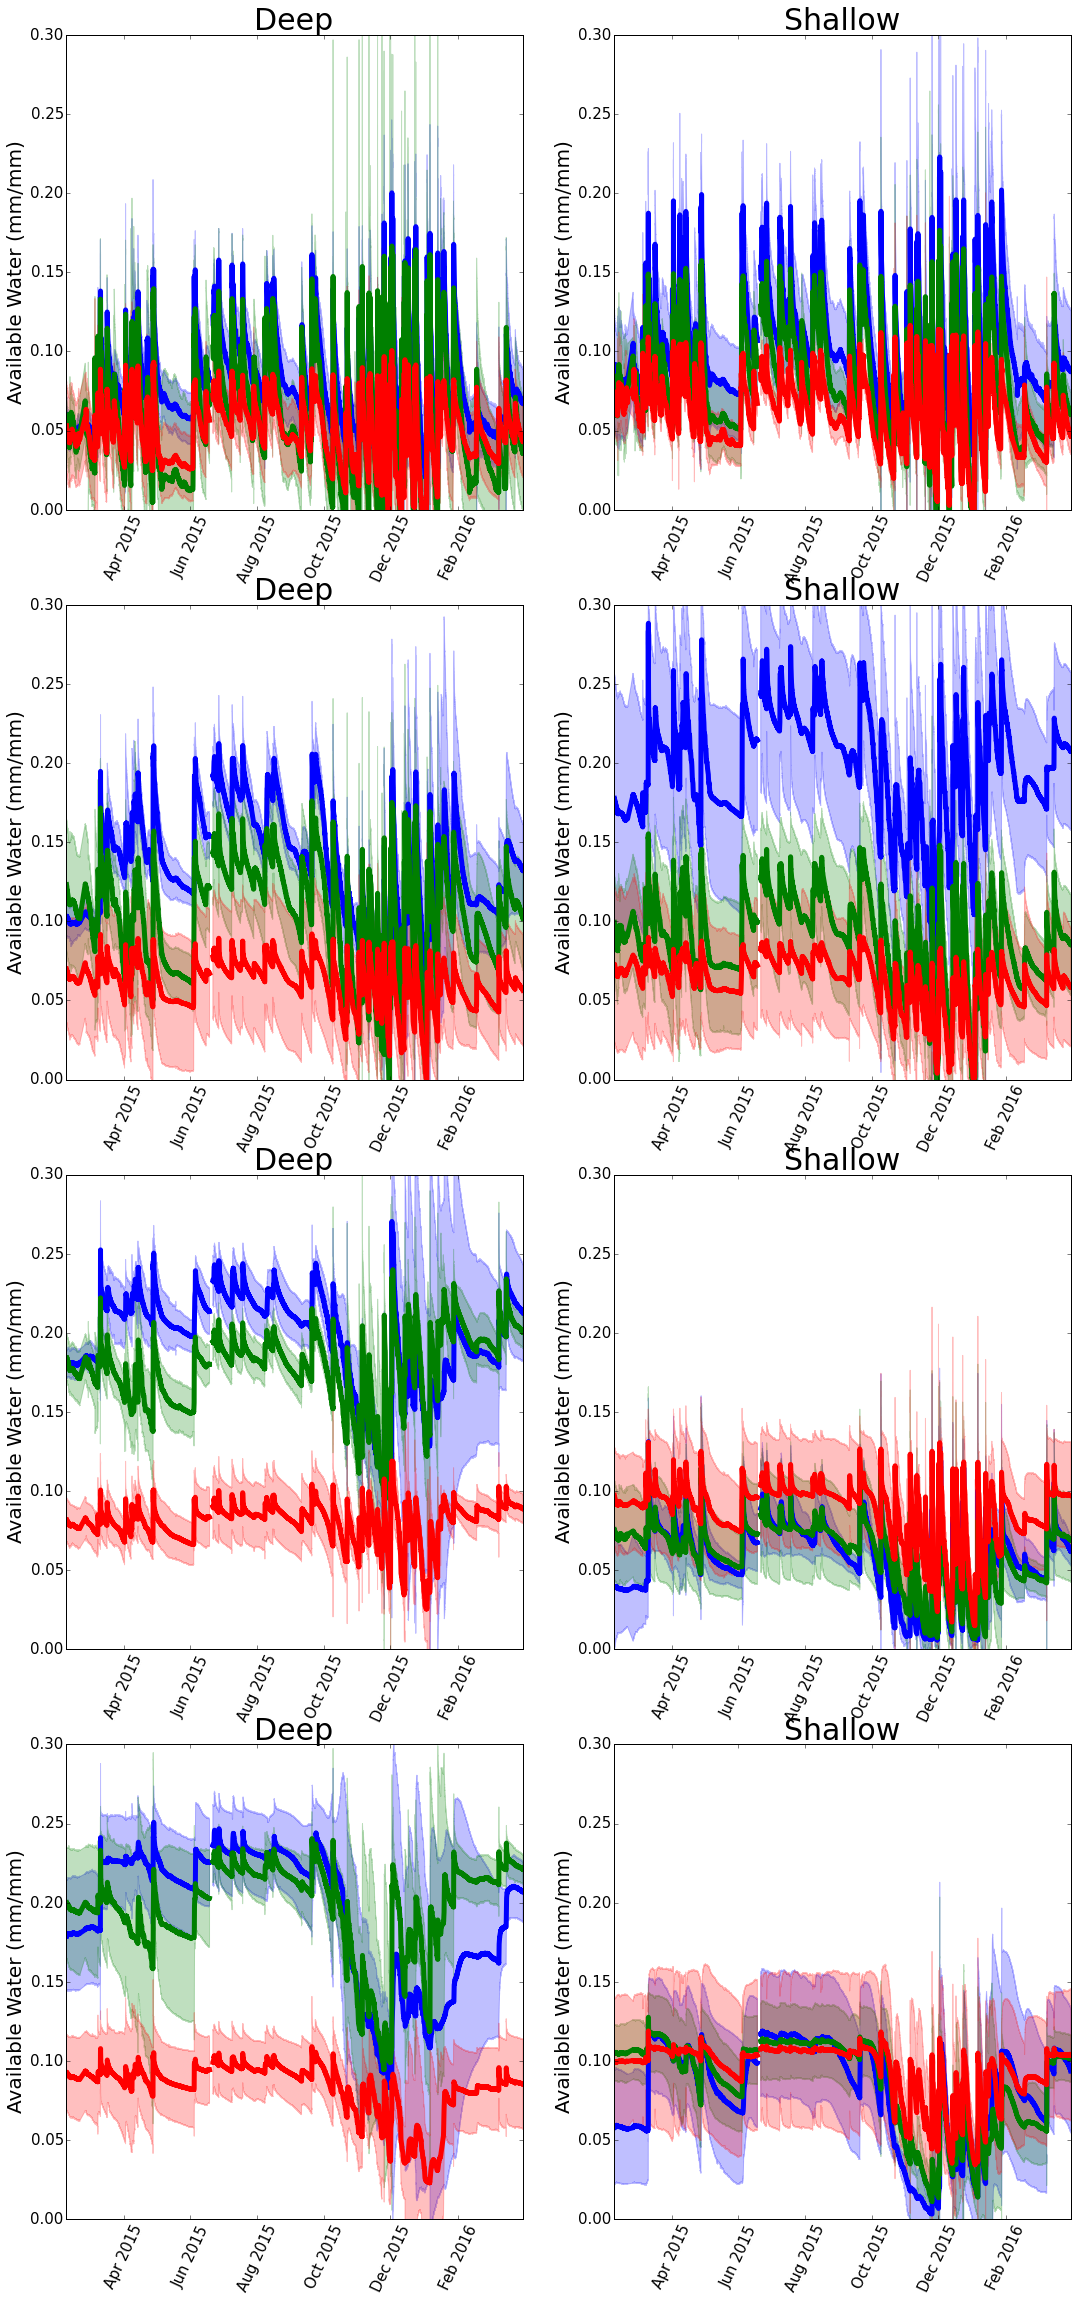

In [79]:
Depths = ['D1','D2','D3','D4']
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,80))

Pos = 1
for Depth in Depths:    
    for Grav in Gravels:
        fig = Graph.add_subplot(8,2,Pos)
        StonPos = 0
        for Ston in Stones:
            median = PAW.ix[:,(Depth,Grav,Ston)].median(axis=1)
            SE = PAW.ix[:,(Depth,Grav,Ston)].std(axis=1)
            Upper = median + SE *2
            Lower = median - SE *2
            plt.fill_between(PAW.ix[:,(Depth,Grav,Ston)].index,
                     Upper,
                     Lower,
                     color = colors[StonPos],alpha=0.25)
            plt.plot(PAW.ix[:,(Depth,Grav,Ston)].index,median,color=colors[StonPos],
                     linewidth = 5,
                     label = Grav+' ' +Ston)
            StonPos += 1
            plt.title(Grav, fontsize=30)
        Pos +=1
        plt.ylim(0,0.3)
        plt.ylabel('Available Water (mm/mm)', fontsize=20)
        plt.xticks(rotation=65)
        plt.tick_params(labelsize=15)    
        #plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

##Set up a series with DUL values and assign these to HorizonIndex

In [80]:
#Assume values on 26 June represent DUL.  This was following large rainfall on the 24th of June allowing two 
#days of drainage.  ET was very low during these two days so evaporative losses would have been small.
DULValues = Data.ix['2015-06-26 12:00:00',:].copy()

#Get rid of all the index columns that I don't need leaving only the sensor reference as an index
DULValues.columns = DULValues.columns.droplevel('Gravels')
DULValues.columns = DULValues.columns.droplevel('Stones')
DULValues.columns = DULValues.columns.droplevel('Column')
DULValues.columns = DULValues.columns.droplevel('Depth')
DULValues.columns = DULValues.columns.droplevel('MUX')
DULValues.columns = DULValues.columns.droplevel('Port')
DULValues.columns = DULValues.columns.droplevel('Units')
DULValues.columns = DULValues.columns.droplevel('Summary')
DULValues.columns = DULValues.columns.droplevel('Block')
DULValues.columns = DULValues.columns.droplevel('Treatment')

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    HorizonIndex.ix[X,'DUL'] = DULValues.ix['2015-06-26 12:00:00',SensorRef] 

##Create and populate a Relative Plant Available Water (RPAW) data frame

In [81]:
#Set up empty dataframe with the same index and column structure as TDR data to hold Relative Plant Available Water values
PAW.columns = PAW.columns.swaplevel('Sensor','Depth')

RPAW = pd.DataFrame(index = PAW.index, columns = PAW.columns)  

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    Horizon = HorizonIndex.ix[X,'Horizon']
    LL = SensorCoefficients.ix[Horizon,'LL']
    PAWC = HorizonIndex.ix[X,'DUL'] - LL
    RPAW[SensorRef] = PAW[SensorRef].divide(PAWC)
    
PAW.columns = PAW.columns.swaplevel('Sensor','Depth')
RPAW.columns = RPAW.columns.swaplevel('Sensor','Depth')

##Graph Relative Plant Available Water

<function matplotlib.pyplot.tight_layout>

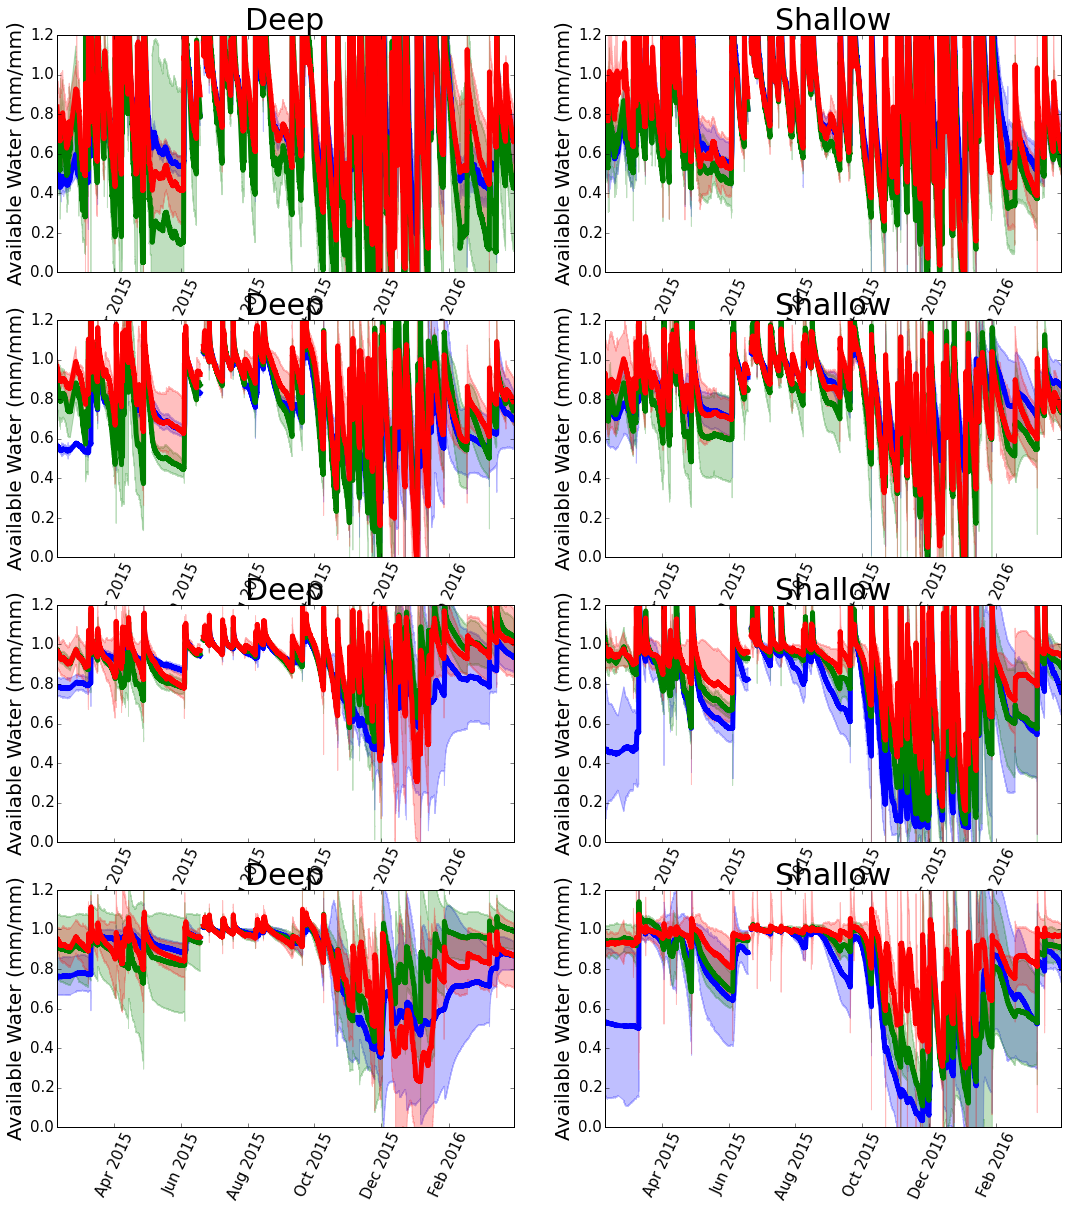

In [82]:
Depths = ['D1','D2','D3','D4']
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,40))

Pos = 1
for Depth in Depths:    
    for Grav in Gravels:
        fig = Graph.add_subplot(8,2,Pos)
        StonPos = 0
        for Ston in Stones:
            median = RPAW.ix[:,(Depth,Grav,Ston)].median(axis=1)
            SE = RPAW.ix[:,(Depth,Grav,Ston)].std(axis=1)
            Upper = median + SE *2
            Lower = median - SE *2
            plt.fill_between(RPAW.ix[:,(Depth,Grav,Ston)].index,
                     Upper,
                     Lower,
                     color = colors[StonPos],alpha=0.25)
            plt.plot(RPAW.ix[:,(Depth,Grav,Ston)].index,median,color=colors[StonPos],
                     linewidth = 5,
                     label = Grav+' ' +Ston)
            StonPos += 1
            plt.title(Grav, fontsize=30)
        Pos +=1
        plt.ylim(0,1.2)
        plt.ylabel('Available Water (mm/mm)', fontsize=20)
        plt.xticks(rotation=65)
        plt.tick_params(labelsize=15)    
        #plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

##Calculate crop water use

Gravels  Stones   
Deep     StoneFree   -0.247042
         Stony       -0.327228
         VeryStony   -0.173063
Shallow  StoneFree   -0.273035
         Stony       -0.279323
         VeryStony   -0.189328
dtype: float64

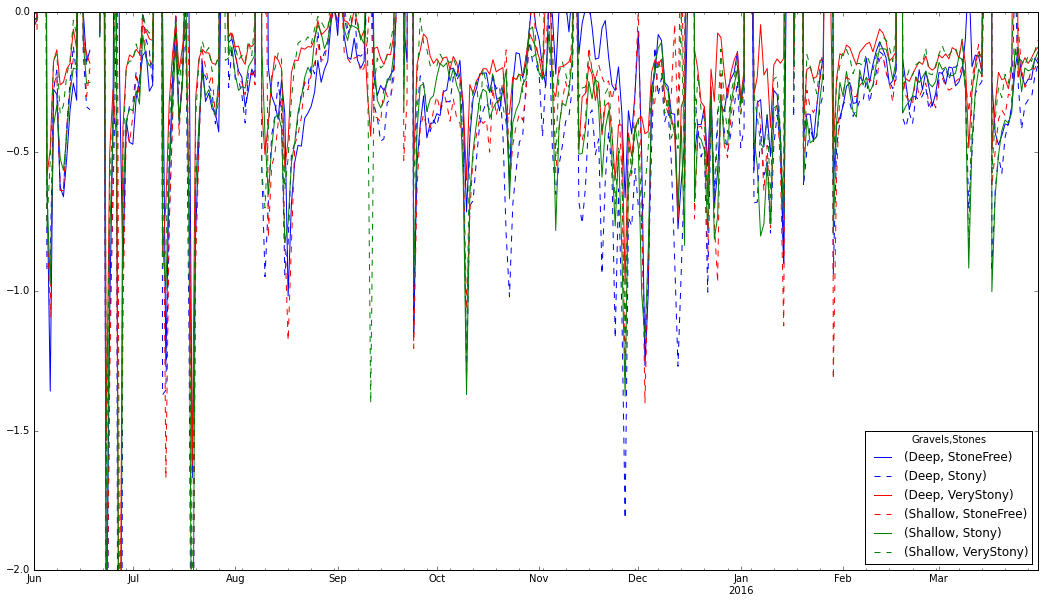

In [83]:
WaterDelta = ProfileWater.ix['2015-06-01':,:].diff()
DarkWaterDeltas = WaterDelta.ix[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(5))]
DarkWaterDeltas = DarkWaterDeltas.resample('D', how='sum')
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Gravels', 'Stones'],axis=1).mean()
MeanDarkWaterDeltas.plot( figsize=(18,10), style=['b-','b--','r-','r--','g-','g--'])
plt.ylim(-2,0)
MeanDarkWaterDeltas.median(axis=0)

In [84]:
IrrigationDates = ['2014-12-22',
'2015-01-12',
'2015-01-13',
'2015-01-21',
'2015-01-26',
'2015-03-10',
'2015-04-01',
'2015-04-02',
'2015-04-07',
'2015-04-08',
'2015-10-09',
'2015-10-22',
'2015-11-02',
'2015-11-05',
'2015-11-11',
'2015-11-19',
'2015-11-23',
'2015-11-25',
'2015-11-25',
'2015-11-30',
'2015-12-01',
'2015-12-02',
'2015-12-03',
'2015-12-11',
'2015-12-14',
'2015-12-23',
'2015-12-24',
'2016-01-06',
'2016-01-13',
'2016-03-09',
'2016-03-28']

IrrigationAmounts = [16.80,
15.70,
16.00,
18.50,
18.36,
47.00,
10.00,
10.00,
10.00,
5.00,
40.00,
20.00,
21.00,
21.00,
20.00,
20.00,
21.00,
19.00,
20.00,
18.50,
20.50,
37.00,
18.00,
21.00,
22.00,
40,
20,
43.00,
40.50,
20,
0]

Irrigation = pd.DataFrame(index=IrrigationDates, data=IrrigationAmounts,columns=['Irrigation'])
Irrigation.index = Irrigation.index.to_datetime()
DailyIrrigation = Irrigation.resample('D',how='sum')
DailyIrrigation.replace(to_replace=np.nan,value=0,inplace=True)

#Add irrigation and rainfall together to give precipitation
Precip = MetData.ix[:,'Rain'].add(DailyIrrigation.ix['2015-06-01':,'Irrigation'])
PrecipMask = Precip.where(Precip<5,1000000)
PrecipMask = PrecipMask.where(PrecipMask==1000000,1)
PrecipMask = PrecipMask.where(PrecipMask==1,np.nan)

In [85]:
CropDates = ['2015-06-19',
'2015-07-19',
'2015-08-01',
'2015-10-25',
'2015-11-16',
'2015-11-25',
'2015-12-14',
'2015-12-30',
'2016-01-11',
'2016-01-20',
'2016-02-20',
'2016-03-28']

CoverData = [0.00,
0.00,
0.05,
0.65,
0.82,
0.83,
0.86,
0.92,
0.79,
0.42,
0.00,
0.00]

CropCover = pd.DataFrame(index=CropDates, data=CoverData, columns = ['Cover'])

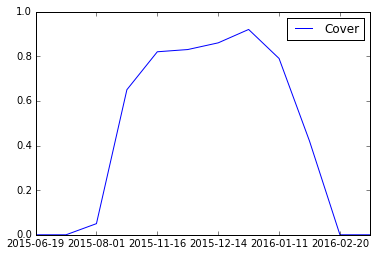

In [86]:
CropCover.plot()

Full Cover from 1-nov to 20-Jan

In [87]:
#Set up daily water use sums
WaterUseDaily = WaterDelta.ix['2015-06-19':,:].resample('D', how='sum')
WaterUseDaily.index.name = 'Date'

#Subtract irrigation to give water use values
WaterUseDaily = WaterUseDaily.subtract(Precip.ix['2015-06-19':], axis=0)
WaterUseDaily = WaterUseDaily.add(Drainage.values, axis=0)

(-10, 1000)

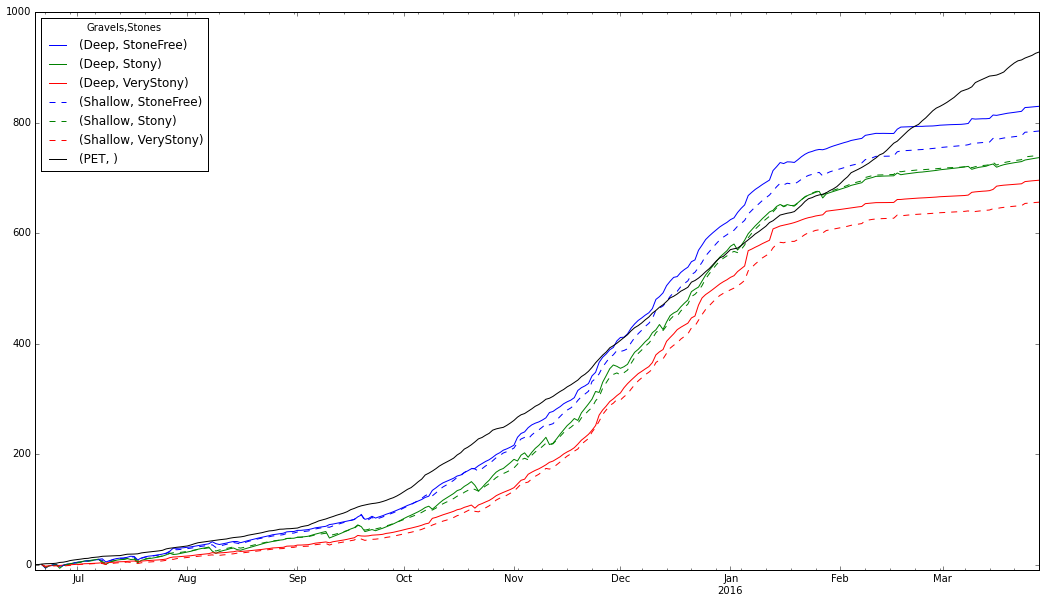

In [88]:
#calculate treatment means
WaterUseDailyMeans = WaterUseDaily.ix[:'2016-03-28'].groupby(level=['Gravels', 'Stones'],axis=1).mean()
#Make water use positive
WaterUseDailyMeans = WaterUseDailyMeans.multiply(-1)

PrecipMask2 = pd.DataFrame(index = WaterUseDailyMeans.index, columns = WaterUseDailyMeans.columns)
for x in range(6):
    PrecipMask2.ix[:,x]=PrecipMask
                          
#WaterUseDailyMeans = WaterUseDailyMeans.multiply(PrecipMask2)
WaterUseDailyMeans['PET'] = MetData.ix['2015-06-19':,'ET']

#plot results
WaterUseDailyMeans.cumsum().plot( figsize=(18,10),style=['b-','g-','r-','b--','g--','r--','k-'])#ylim = (-1,17),
plt.ylim(-10,1000)
#plt.plot(MetData.ix['2015-06-19':,'ET'].index,MetData.ix['2015-06-19':,'ET'],'-',linewidth =10)

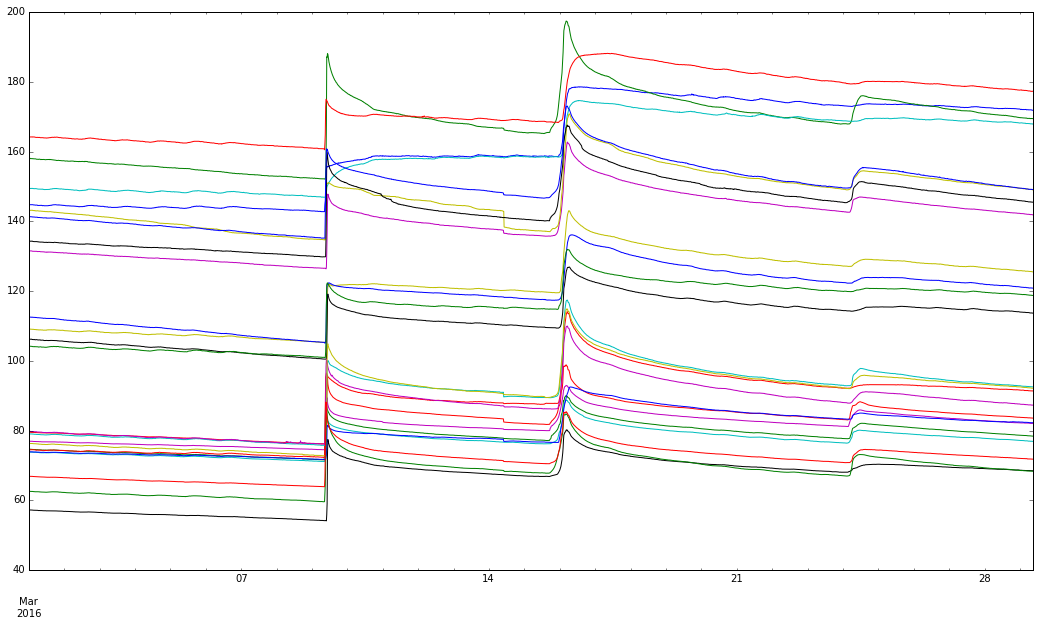

In [43]:
ProfileWater.ix['2016-03-01':].plot(figsize=(18,10),legend=False)

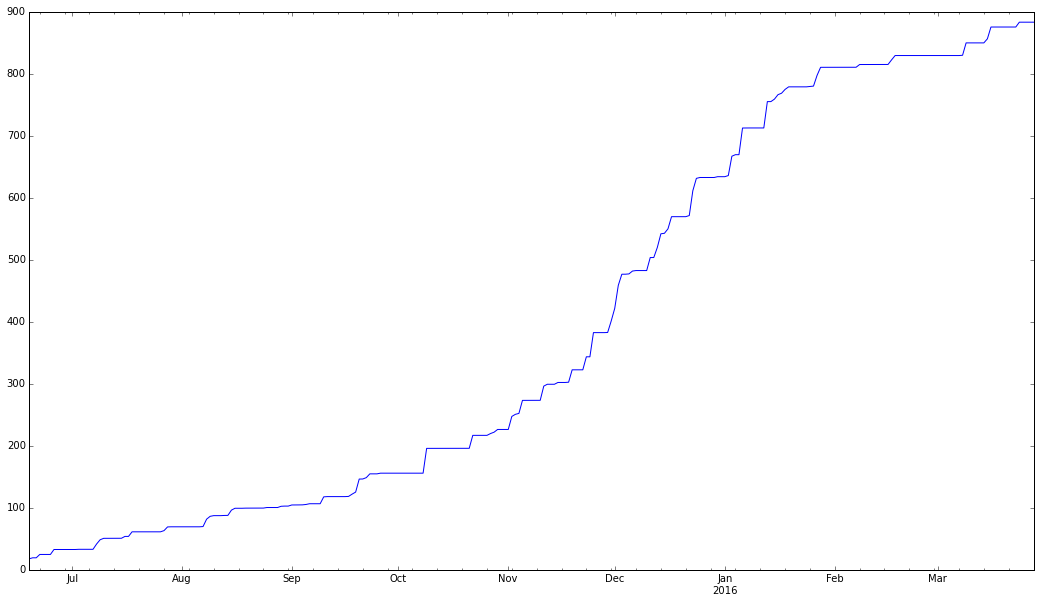

In [64]:
Precip.ix['2015-06-19':].cumsum().plot(figsize=(18,10))

In [ ]:
.values[0]

<function matplotlib.pyplot.tight_layout>

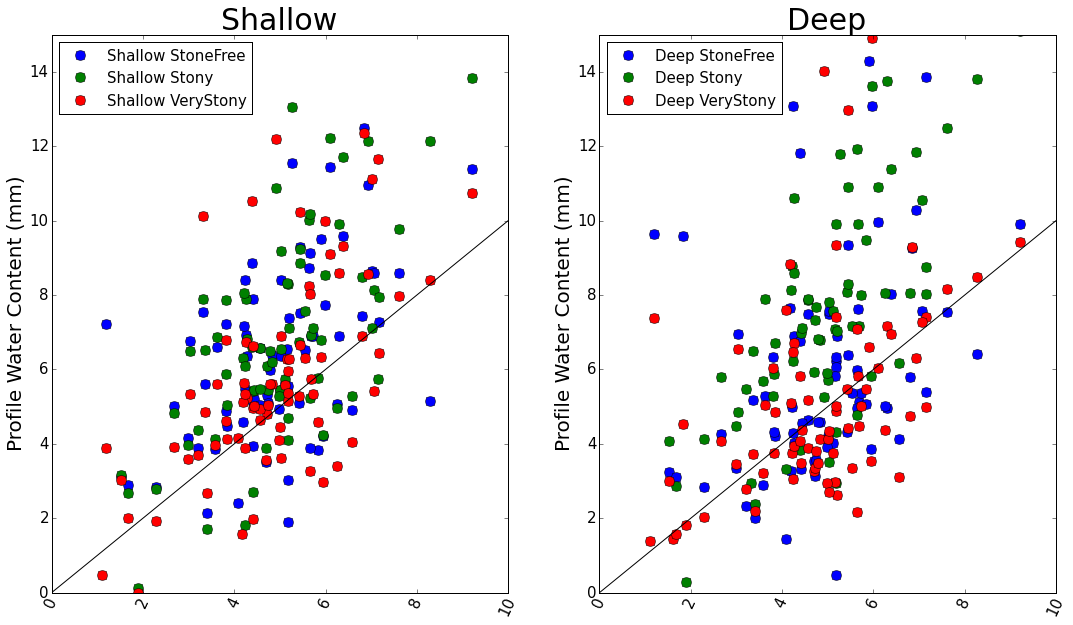

In [89]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,10))

GravPos = 0
for Grav in Gravels:
    fig = Graph.add_subplot(1,2,GravPos)
    StonPos = 0
    for Ston in Stones:
        plt.plot(MetData.ix['2015-11-1':'2016-01-20','ET'],WaterUseDailyMeans.ix['2015-11-1':'2016-01-20',(Grav,Ston)],
                 'o',
                 markersize=10,
                 color=colors[StonPos],
                 label = Grav+' ' +Ston)
        StonPos += 1
        plt.title(Grav, fontsize=30)
    GravPos +=1
    plt.ylim(0,15)
    plt.ylabel('Profile Water Content (mm)', fontsize=20)
    plt.xticks(rotation=65)
    plt.tick_params(labelsize=15)    
    plt.legend(loc=2,numpoints=1,fontsize = 15)
    plt.plot([0,10],[0,10],'-',color='k')
plt.tight_layout

##Calculate Water Extraction Rate (WER) each day and graph

<function matplotlib.pyplot.tight_layout>

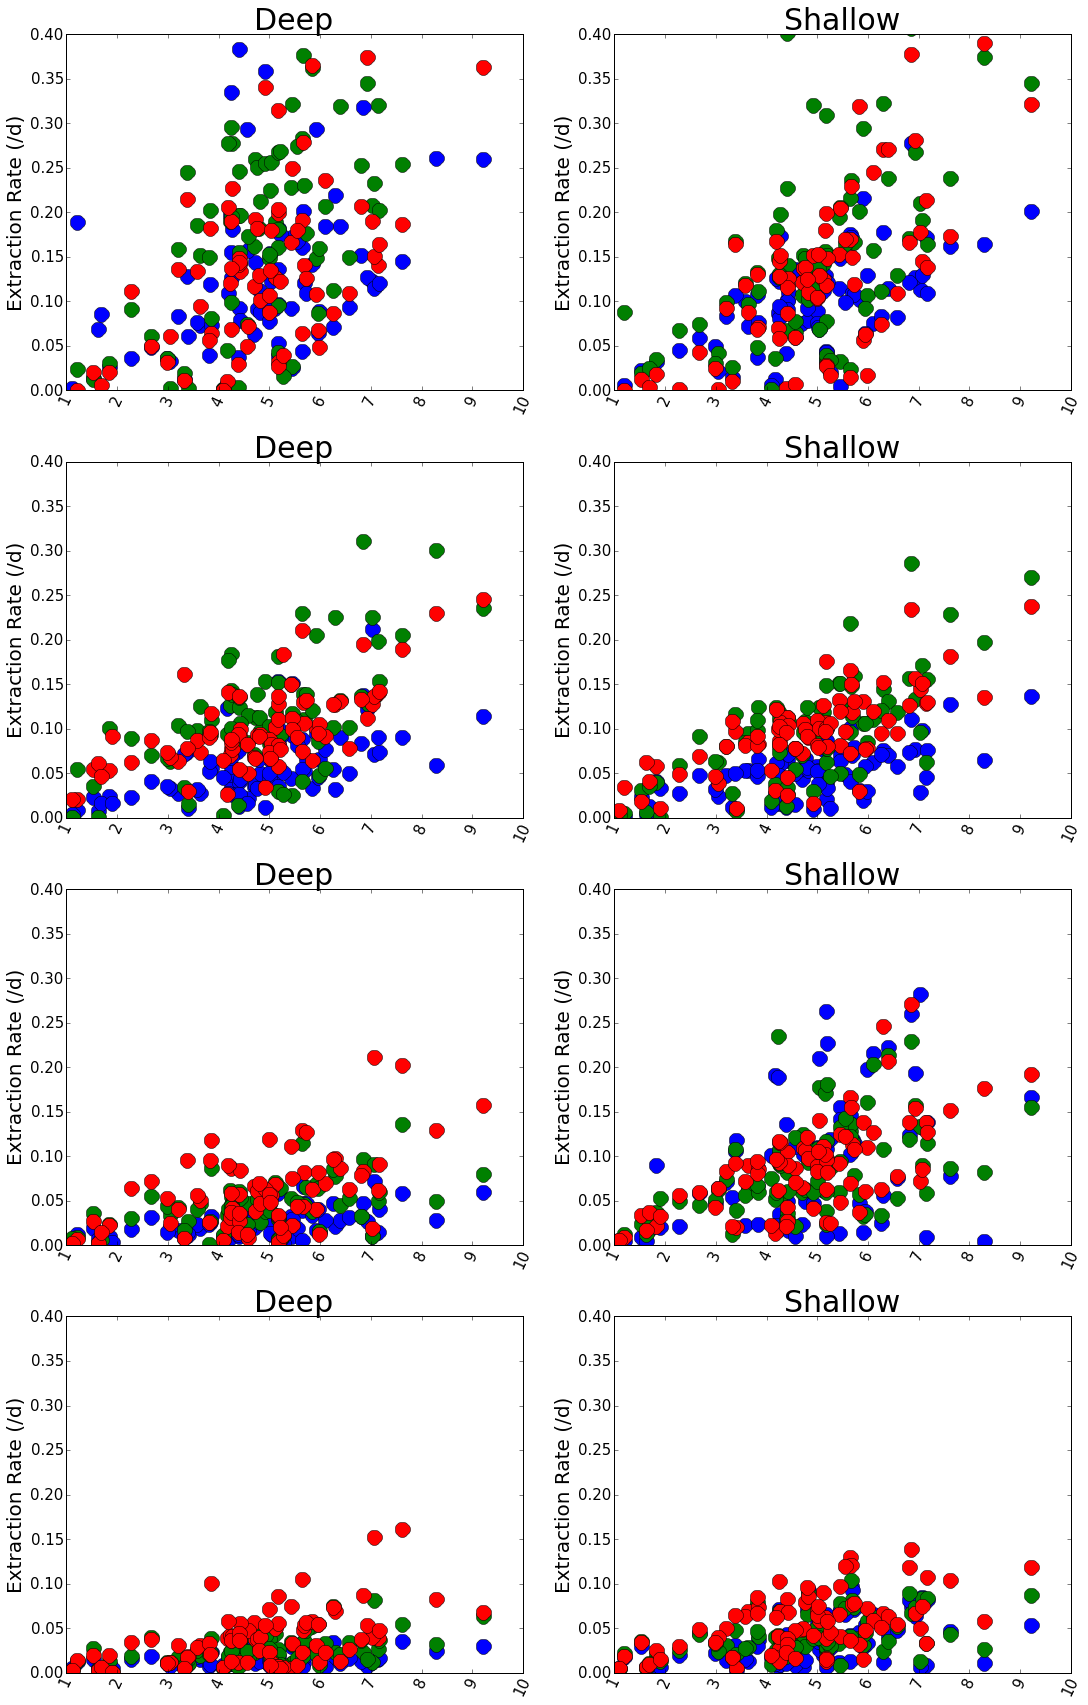

In [90]:
#Water Extraction Rate is the proportion of plant available water that is extracted each day so calculated as the difference between 
#RPAW each day
#Calculate Rate
WER = RPAW.ix['2015-06-19':,:].diff() * -1
#Throw away values that are ridiculiously high rates
WER.where(RPAW.ix['2015-06-19':,:]<0.98,np.nan,inplace=True)
#Throw away any data where rates are negative, water recharge is occuring
WER.where(WER>0,np.nan,inplace=True)
#Agregate to daily values
DailyWER = WER.resample('D', how ='sum')
#Remove any data where drainage was occuring
DailyWER.where(DrainageMask!=np.nan,np.nan)
#Drop data when canopy cover was less than 80%
DailyWER = DailyWER.ix['2015-11-1':'2016-01-20',:]

Depths = ['D1','D2','D3','D4']
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,60))

Pos = 1
for Depth in Depths:    
    for Grav in Gravels:
        fig = Graph.add_subplot(8,2,Pos)
        StonPos = 0
        for Ston in Stones:
            median = DailyWER.ix[:,(Depth,Grav,Ston)].median(axis=1)
            plt.plot(MetData.ix[median.index,'ET'],median,'o',color=colors[StonPos],
                     markersize = 15,
                     label = Grav+' ' +Ston)
            StonPos += 1
            plt.title(Grav, fontsize=30)
        Pos +=1
        plt.ylim(0,0.4)
        plt.ylabel('Extraction Rate (/d)', fontsize=20)
        plt.xticks(rotation=65)
        plt.tick_params(labelsize=15)    
        #plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

In [91]:
TreatComb_tup = [('D1','Deep','StoneFree'),
('D1','Deep','Stony'),
('D1','Deep','VeryStony'),
('D1','Shallow','StoneFree'),
('D1','Shallow','Stony'),
('D1','Shallow','VeryStony'),
('D2','Deep','StoneFree'),
('D2','Deep','Stony'),
('D2','Deep','VeryStony'),
('D2','Shallow','StoneFree'),
('D2','Shallow','Stony'),
('D2','Shallow','VeryStony'),
('D3','Deep','StoneFree'),
('D3','Deep','Stony'),
('D3','Deep','VeryStony'),
('D3','Shallow','StoneFree'),
('D3','Shallow','Stony'),
('D3','Shallow','VeryStony'),
('D4','Deep','StoneFree'),
('D4','Deep','Stony'),
('D4','Deep','VeryStony'),
('D4','Shallow','StoneFree'),
('D4','Shallow','Stony'),
('D4','Shallow','VeryStony')]

TreatCombs = pd.MultiIndex.from_tuples(TreatComb_tup,names=('Depth','Gravels','Stones'))

KLparamFits = pd.DataFrame(index = TreatCombs, columns = ['Klmax','Klo'])

##Interpreting Water Extraction rates
There is daily variation in WER within each layer.  This is because on many days water extraction is limited by atmospherid demand.  It is the maximimum (excluding some outlyers) that represents the potential water extraction rate (kl) given by the soil hydraulic conductivity (k) and the crop root length density (l).

To calculate kl we will take the 80th percentile of WER for each layer

##Calculate kl values for each treatment and graph

In [182]:
DailyWER.columns = DailyWER.columns.swaplevel('Sensor','Depth')
DailyWER.dropna(inplace = True)

kl = pd.DataFrame(columns = Data.columns.swaplevel('Sensor','Depth'))

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    kl.ix['kl',SensorRef] = np.percentile(DailyWER.ix[MetData.ix[DailyWER[SensorRef].index,'ET']>6,SensorRef],50)

DailyWER.columns = DailyWER.columns.swaplevel('Sensor','Depth')
#For some reason the above opperation makes numbers into object types so need to convert them to floats.
kl = kl.astype(float)   

#Calculate means
klMeans = kl.groupby(level=['Gravels','Stones','Depth'],axis=1).mean()
#turn the index columns into data so it can be graphed
kltranspose = klMeans.transpose()

(0, 0.3)

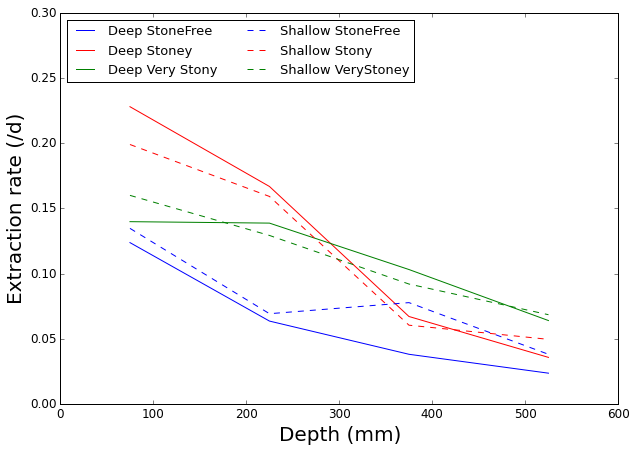

In [183]:
#Fig = plt.figure(figsize=(10,10))
#plt.plot(kltranspose.index,kltranspose.ix[('Deep','StoneFree')])
depth = [75,225,375,525]
Fig = plt.figure(figsize=(10,7))
plt.plot(depth,kltranspose.ix[('Deep','StoneFree')].values,'b-', label='Deep StoneFree')
plt.plot(depth,kltranspose.ix[('Deep','Stony')].values,'r-', label='Deep Stoney')
plt.plot(depth,kltranspose.ix[('Deep','VeryStony')].values,'g-', label='Deep Very Stony')
plt.plot(depth,kltranspose.ix[('Shallow','StoneFree')].values,'b--', label='Shallow StoneFree')
plt.plot(depth,kltranspose.ix[('Shallow','Stony')].values,'r--', label='Shallow Stony')
plt.plot(depth,kltranspose.ix[('Shallow','VeryStony')].values,'g--', label='Shallow VeryStoney')
plt.legend(loc=2, fontsize=13, ncol=2)
plt.ylabel('Extraction rate (/d)', fontsize=20);
plt.xlabel('Depth (mm)', fontsize=20);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,0.3)

In [184]:
klRO = kl.swaplevel('Block','Sensor',axis=1)
klRO = klRO.transpose()
klRO = klRO.sort()
klRO = klRO.transpose()

Depths = ['D1','D2','D3','D4']
TreatComb_tup = [('1','Deep','StoneFree'),
('1','Deep','Stony'),
('1','Deep','VeryStony'),
('1','Shallow','StoneFree'),
('1','Shallow','Stony'),
('1','Shallow','VeryStony'),
('2','Deep','StoneFree'),
('2','Deep','Stony'),
('2','Deep','VeryStony'),
('2','Shallow','StoneFree'),
('2','Shallow','Stony'),
('2','Shallow','VeryStony'),
('3','Deep','StoneFree'),
('3','Deep','Stony'),
('3','Deep','VeryStony'),
('3','Shallow','StoneFree'),
('3','Shallow','Stony'),
('3','Shallow','VeryStony'),
('4','Deep','StoneFree'),
('4','Deep','Stony'),
('4','Deep','VeryStony'),
('4','Shallow','StoneFree'),
('4','Shallow','Stony'),
('4','Shallow','VeryStony')]

TreatCombs = pd.MultiIndex.from_tuples(TreatComb_tup,names=('Block','Gravels','Stones'))

klstack = pd.DataFrame(index = Depths, columns = TreatCombs)

klstack.ix['D1',:] = klRO.ix[:,klRO.columns.isin(['D1'],level='Depth')].values[0]
klstack.ix['D2',:] = klRO.ix[:,klRO.columns.isin(['D2'],level='Depth')].values[0]
klstack.ix['D3',:] = klRO.ix[:,klRO.columns.isin(['D3'],level='Depth')].values[0]
klstack.ix['D4',:] = klRO.ix[:,klRO.columns.isin(['D4'],level='Depth')].values[0]
klstack = klstack.swaplevel('Block','Gravels',axis=1)
klstack = klstack.swaplevel('Block','Stones',axis=1)

<function matplotlib.pyplot.tight_layout>

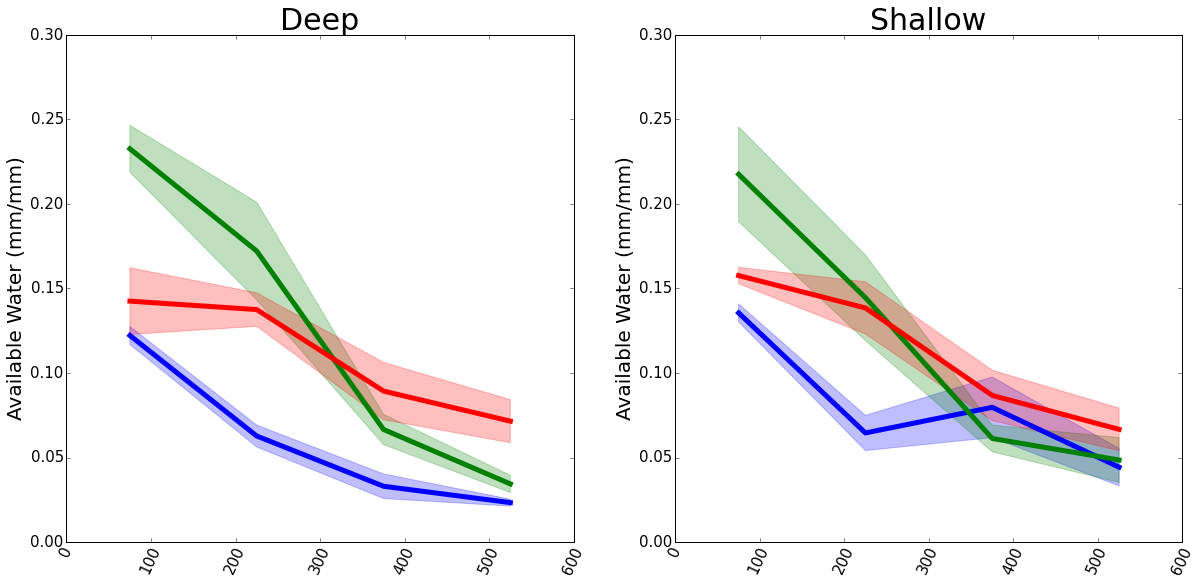

In [185]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']
depth = [75,225,375,525]

Graph = plt.figure(figsize=(20,20))

Pos = 1
for Grav in Gravels:
    fig = Graph.add_subplot(2,2,Pos)
    StonPos = 0
    for Ston in Stones:
        median = klstack.ix[:,(Grav,Ston)].median(axis=1)
        SEM = klstack.ix[:,(Grav,Ston)].std(axis=1)/np.sqrt(4)
        Upper = median + SEM
        Lower = median - SEM
        plt.fill_between(depth,
                 Upper,
                 Lower,
                 color = colors[StonPos],alpha=0.25)
        plt.plot(depth,median,color=colors[StonPos],
                 linewidth = 5,
                 label = Grav+' ' +Ston)
        StonPos += 1
        plt.title(Grav, fontsize=30)
    Pos +=1
    plt.ylim(0,0.3)
    plt.ylabel('Available Water (mm/mm)', fontsize=20)
    plt.xticks(rotation=65)
    plt.tick_params(labelsize=15)    
    #plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

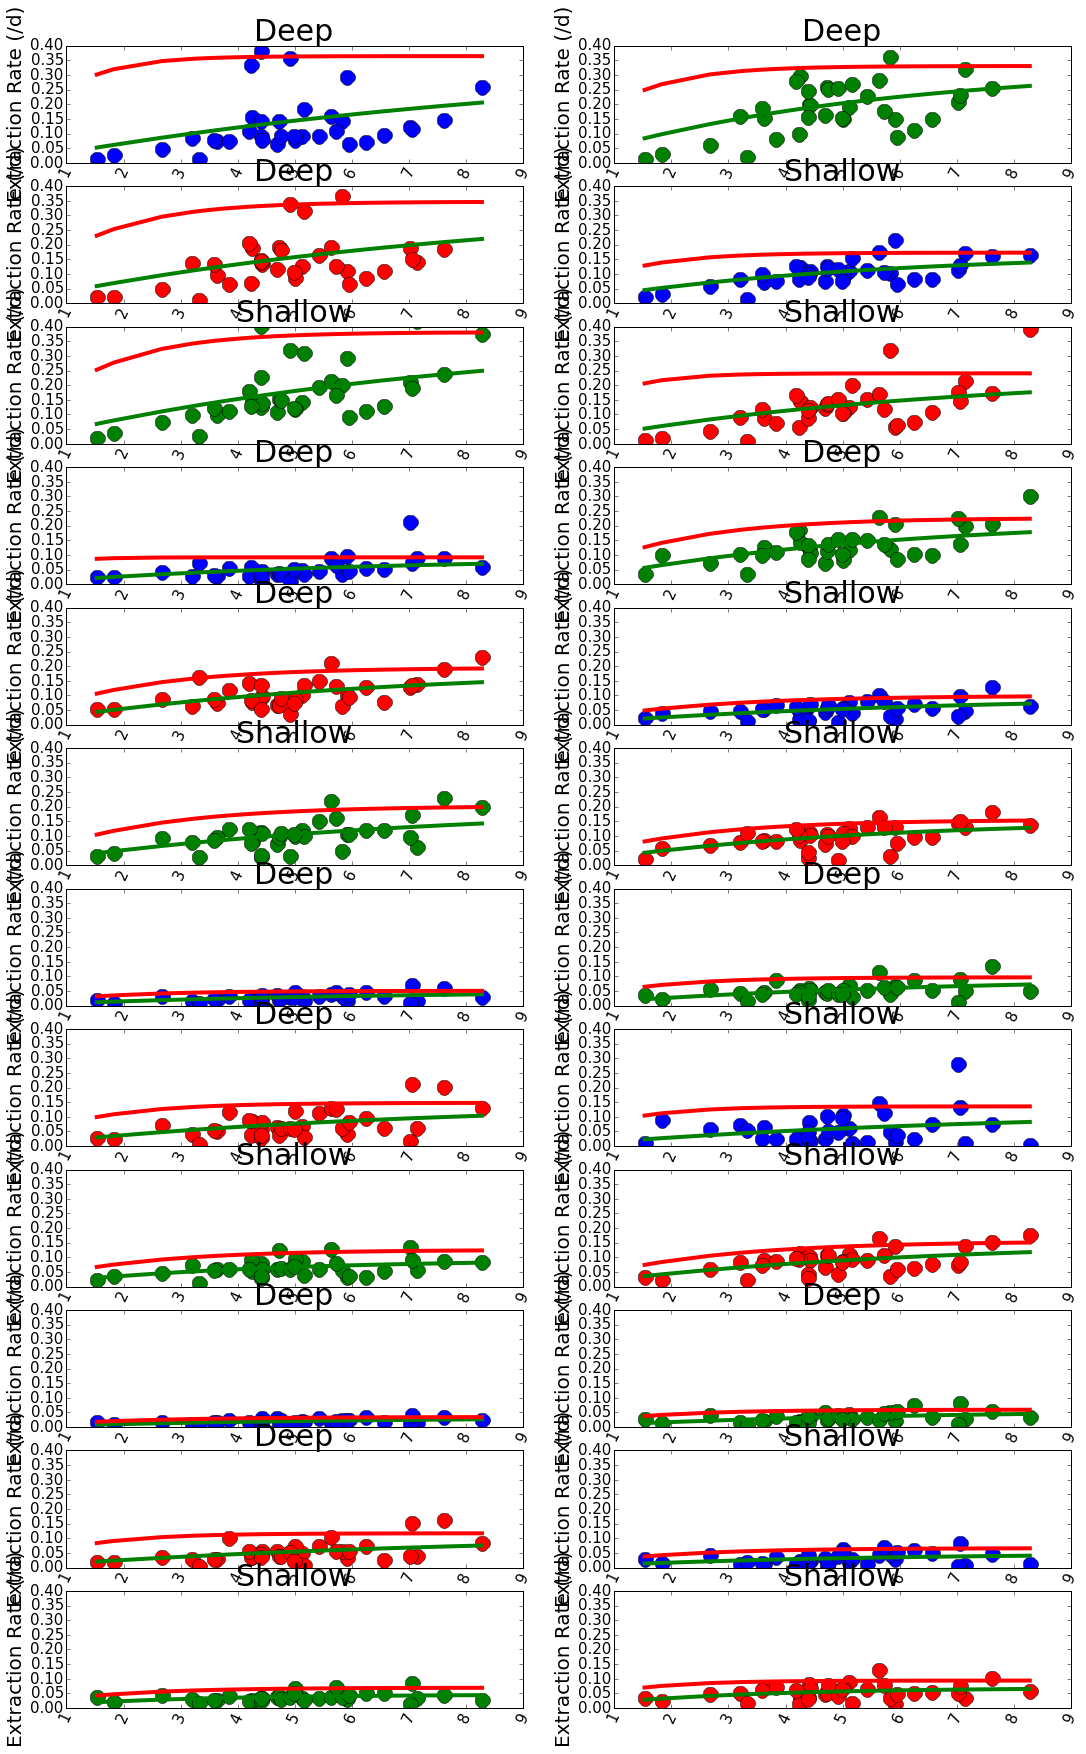

In [98]:
#Define function to be fit
Exponental = fitter.models.ExpressionModel('Klmax - Klmax * exp(x * -Klo)')  #Exponential curve

Fig = plt.figure(figsize=(18, 80))
    
#Fit curve to upper envelope of data to give potential yield model
Depths = ['D1','D2','D3','D4']
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,60))

Pos = 1
for Depth in Depths:    
    for Grav in Gravels:
        StonPos = 0
        for Ston in Stones:
            fig = Graph.add_subplot(24,2,Pos)
            #Setup x and y arrays
            y = DailyWER.ix['2015-11-1':'2016-01-20',(Depth,Grav,Ston)].median(axis=1)
            x = MetData.ix[y.index,'ET']
            xplot = x.drop_duplicates()
            xplot.sort()
            

            #Define function to be fit
            Exponental = fitter.models.ExpressionModel('Klmax - Klmax * exp(x * Klo)')  #Exponential curve
            pctle95 = np.percentile(y,95)
            pctle85 = np.percentile(y,85)
            pctle75 = np.percentile(y,75)
            p = fitter.Parameters()
            p.add_many(('Klmax',pctle85,True,pctle75,pctle95,None),
                       ('Klo',-0.3,True,-2,-.01,None))
            
            #fit model
            yBestFit = Exponental.fit(y, p, x=x)
            yplotBest = Exponental.eval(yBestFit.params,x=xplot)

            #calculating weightings
            residuals = pd.Series(yBestFit.residual)
            Weightings = residuals.where(residuals<0.0,0).copy()
            Weightings2 = np.asarray(Weightings)

            #Recrank fitting with weighting toward upper threshold
            yUpperFit = Exponental.fit(y, p, x=x, weights = Weightings2) 
            yplotUpper = Exponental.eval(yUpperFit.params,x=xplot)
            
            plt.plot(MetData.ix[y.index,'ET'],y,'o',color=colors[StonPos],
                     markersize = 15,
                     label = Grav+' ' +Ston)
            plt.title(Grav, fontsize=30)
            plt.plot(xplot,yplotBest,'-',color='g',linewidth = 4)
            plt.plot(xplot,yplotUpper,'-',color='r',linewidth = 4)
            plt.ylim(0,0.4)
            plt.ylabel('Extraction Rate (/d)', fontsize=20)
            plt.xticks(rotation=65)
            plt.tick_params(labelsize=15)    
            Pos +=1
            StonPos += 1
            KLparamFits.ix[(Depth,Grav,Ston),:] = pd.Series(yBestFit.best_values)

In [143]:
#'Klmax - Klmax * exp(x * -Klo)'

#negKlo = np.multiply(-1,KLparamFits.ix[:,'Klo'].values)
xKlo = np.multiply(7,KLparamFits.ix[:,'Klo'].values)
expxKlo = np.exp(np.float64(xKlo)) 
right = np.multiply(expxKlo,KLparamFits.ix[:,'Klmax'].values)
kl7mm = np.subtract(KLparamFits.ix[:,'Klmax'].values,right)
KLparamFits.ix[:,'Kl7mm'] = kl7mm

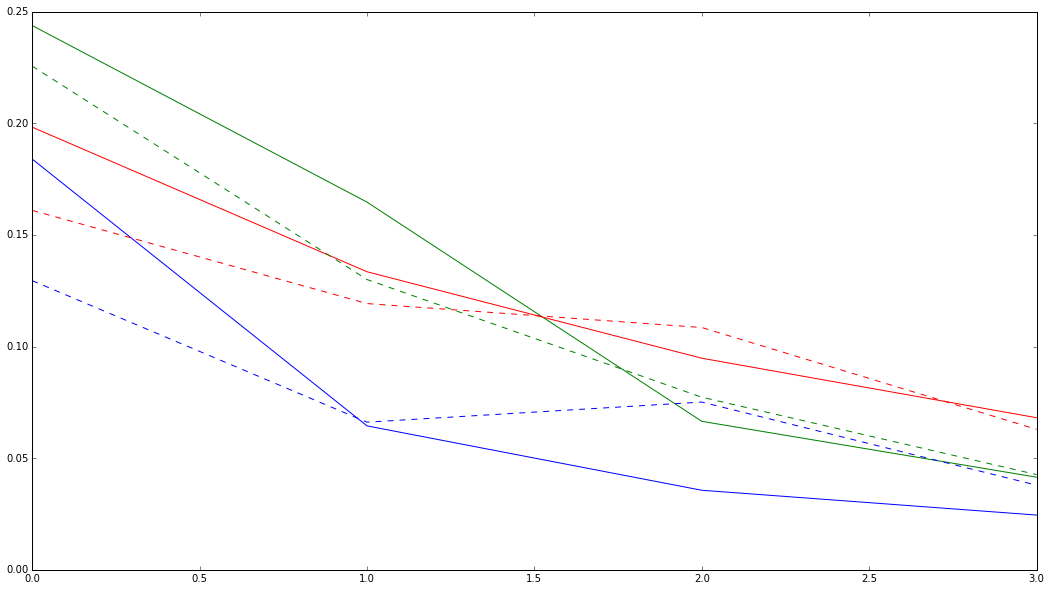

In [146]:
#Plot kl valuse calculated with fitting method
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,10))

GravPos = 0
for Grav in Gravels:
    GravelSelect = KLparamFits.index.isin([Grav],level='Gravels')
    StonPos=0
    for Ston in Stones:
        StoneSelect = KLparamFits.index.isin([Ston],level='Stones')
        #Create a boolean mask for flitering current data out of DataFrame
        mask = [all(tup) for tup in zip(StoneSelect, GravelSelect)]
        y = KLparamFits.ix[mask,'Kl7mm']
        x = KLparamFits.ix[mask,'Kl7mm'].index
        plt.plot(y,lines[GravPos],color=colors[StonPos])
        StonPos +=1
    GravPos +=1